In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from neuralnet import NeuralNetwork


from layers import (
  LinearLayer,
  SigmoidLayer,
  TanhLayer,
  ReluLayer,
  MSEOutputLayer
)

import helpers

# from utils import avgn_attack

%matplotlib inline

In [2]:
def avgn_attack(img, std=0.0, mean=0.1):
    noisy_img = img + np.random.normal(mean, std, img.shape)
    
    # we might get out of bounds due to noise
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    return noisy_img_clipped


In [61]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255

In [62]:
# filename_test = "../data/digit-recognizer/test.csv"
# filename_train = "../data/digit-recognizer/train.csv"

# df_train = pd.read_csv(filename_train, delimiter=',')
# df_test = pd.read_csv(filename_test, delimiter=',')

# X = df_train.loc[:, df_train.columns != "label"]
# y = df_train.loc[:, df_train.columns == "label"]
# X = X.to_numpy()
# y = y.to_numpy()
# print('Dataset: X={}, y={}'.format(X.shape, y.shape))

In [59]:
# X_train, X_test, _, _ = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

# print('Training set: X={}, y={}'.format(X_train.shape, X_train.shape))
# print('Test set: X={}, y={}'.format(X_test.shape, X_test.shape))

In [60]:
# X_train = X_train.reshape(-1, 28*28) / 255
# X_test = X_test.reshape(-1, 28*28) / 255

In [56]:
X_train_noisy = np.array([avgn_attack(x, 0.5, 0.5) for x in X_train])
X_test_noisy = np.array([avgn_attack(x, 0.5, 0.5) for x in X_test])

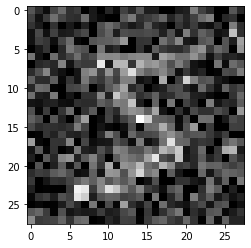

In [57]:
plt.imshow(X_train_noisy[0].reshape(28, 28), 'gray')

In [65]:
# Number of neurons in the first hidden-layer
hidden_neurons_1 = 128

# Number of neurons in the second hidden-layer
hidden_neurons_2 = 64

hidden_neurons_3 = 32

# latent_neurons = 32

# Define a list of layers
net_layers = []

net_layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
net_layers.append(ReluLayer())

net_layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
net_layers.append(ReluLayer())

net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
net_layers.append(ReluLayer())

# net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_3))
# net_layers.append(TanhLayer())

# net_layers.append(LinearLayer(hidden_neurons_3, hidden_neurons_2))
# net_layers.append(TanhLayer())

# net_layers.append(LinearLayer(hidden_neurons_2, hidden_neurons_1))
# net_layers.append(TanhLayer())

net_layers.append(LinearLayer(hidden_neurons_3, X_train.shape[1]))
net_layers.append(SigmoidLayer())

#net_layers.append(SoftmaxOutputLayer())
net_layers.append(MSEOutputLayer())

net = NeuralNetwork()

# Tahh -> Sigmoid ~100

net.fit(X_train_noisy, X_train, X_test_noisy, X_test, net_layers, 
        max_iterations=30, batch_size=128, learning_rate=0.01, output_each_iter=1)

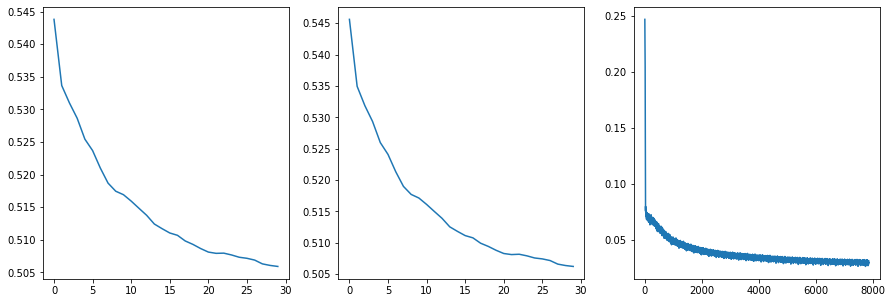

In [31]:
fig, axs_costs = plt.subplots(1, 3, figsize=(15, 5))
axs_costs_ = axs_costs.ravel()
for i, costs in enumerate(
  [net.train_costs, net.val_costs, net.batch_costs]):
  axs_costs_[i].plot(costs)

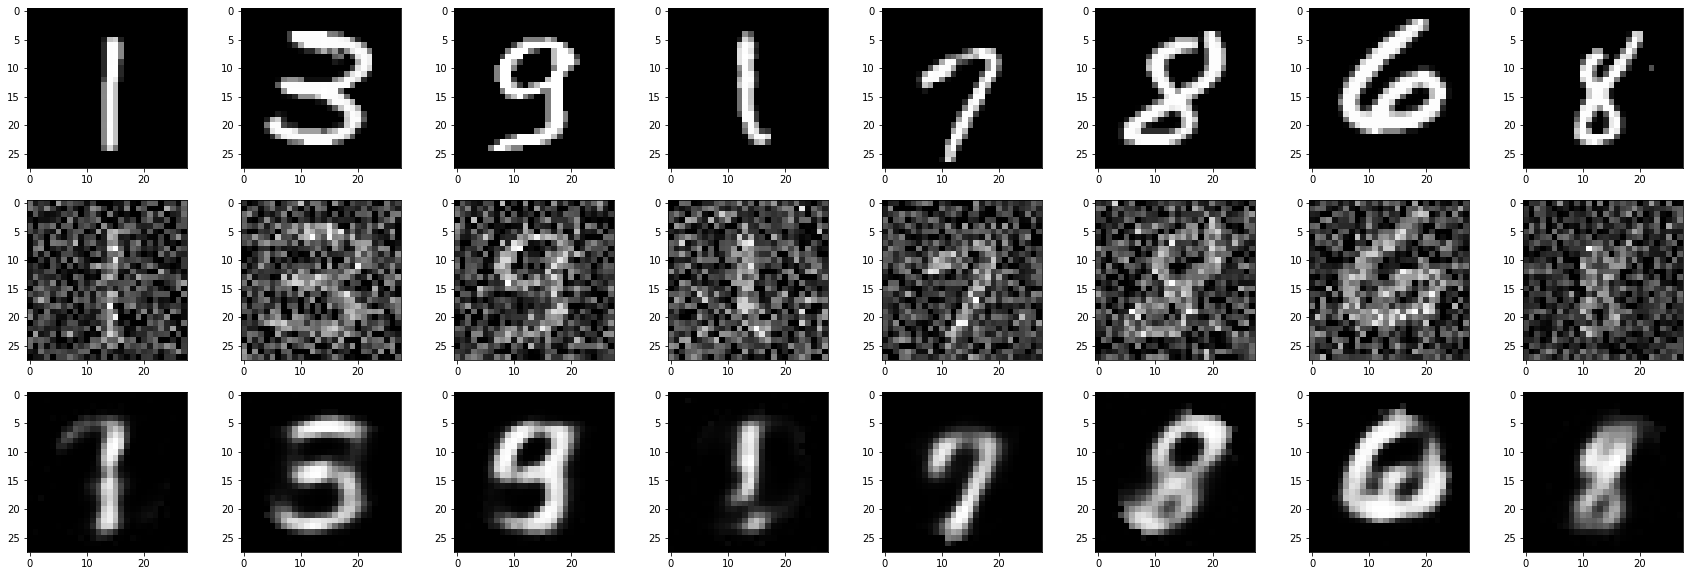

In [49]:
samples_number = 8
idx = 100

samples_true = X_train[idx:idx+samples_number]
samples_noisy = X_train_noisy[idx:idx+samples_number]
autoencoded_samples = net.forward_step(samples_noisy)[-1]

fig, axs = plt.subplots(3, samples_number, figsize=(30, 10))
axs_ = axs.ravel()

for i, (ts, ns, ds) in enumerate(zip(samples_true, samples_noisy, autoencoded_samples)):
  axs_[i].imshow(ts.reshape(28, 28), cmap="gray")
  axs_[(samples_number) + i].imshow(ns.reshape(28, 28), cmap="gray")
  axs_[(2 * samples_number) + i].imshow(ds.reshape(28, 28), cmap="gray")

In [71]:
prefix = "denoising-relu-sigmoid-30-iter-128-batch"
#best - prefix = "denoising-relu-relu-sigmoid-30-iter-128-batch"

In [72]:
# helpers.save_model(net_layers, prefix=prefix)

In [73]:
new_layers = helpers.load_model(prefix)

In [74]:
new_net = NeuralNetwork()
new_net.load_layers(new_layers)

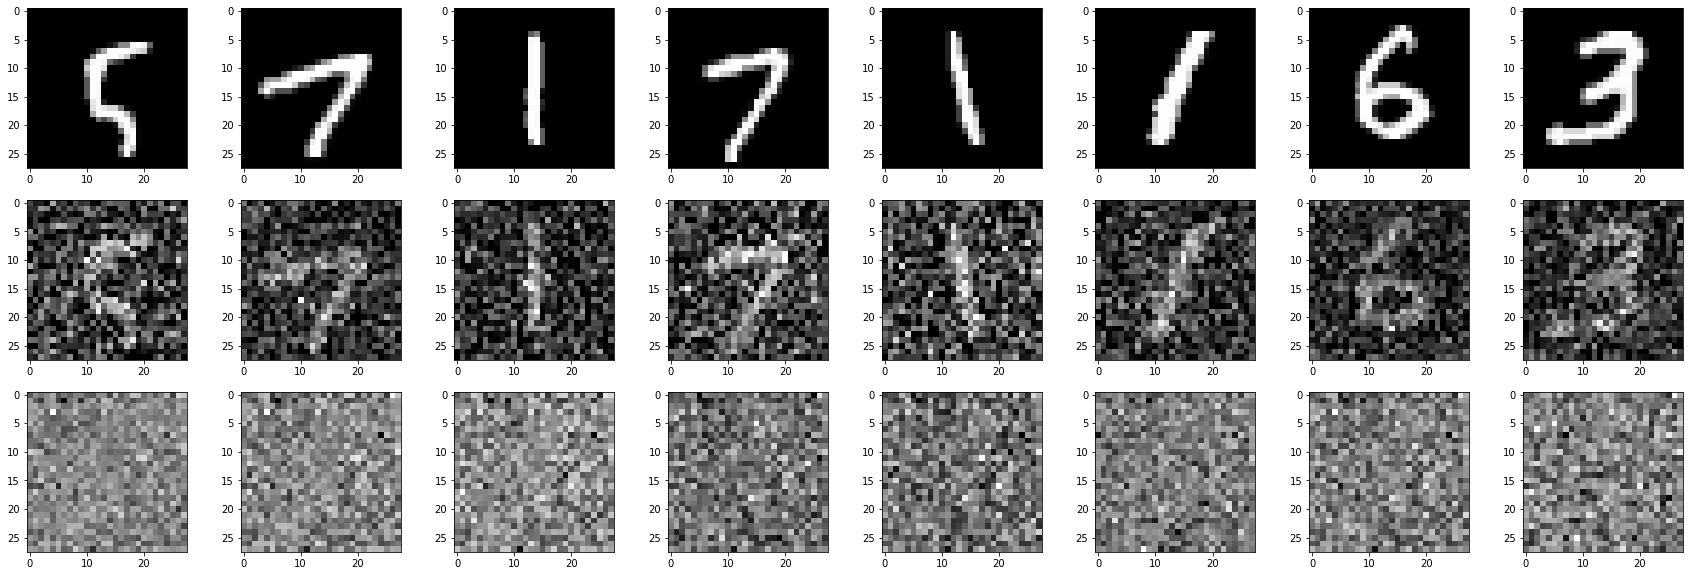

In [75]:
samples_true = X_train[idx:idx+samples_number]
samples_noisy = X_train_noisy[idx:idx+samples_number]
autoencoded_samples = net.forward_step(samples)[-1]

fig, axs = plt.subplots(3, samples_number, figsize=(30, 10))
axs_ = axs.ravel()

for i, (ts, ns, ds) in enumerate(zip(samples_true, samples_noisy, autoencoded_samples)):
  axs_[i].imshow(ts.reshape(28, 28), cmap="gray")
  axs_[(samples_number) + i].imshow(ns.reshape(28, 28), cmap="gray")
  axs_[(2 * samples_number) + i].imshow(ds.reshape(28, 28), cmap="gray")

In [17]:
# sample = X_train[20].reshape(1, -1)
# noisy_sample = avgn_attack(sample, std=0.5, mean=0.5)
# test = noisy_sample.reshape(-1, 1)
# test.shape

In [18]:
# with open('test', 'w') as f:

In [19]:
# plt.imshow(sample.reshape(28, 28), "gray")

In [ ]:
# plt.imshow(noisy_sample.reshape(28, 28), "gray")

In [ ]:
# a = forward_step(sample, layers)

In [ ]:
# plt.imshow(a[-1].reshape(28, 28), "gray")

In [ ]:
# sample

In [ ]:
X_train.shape[1]